In [104]:
import os, sys
import yaml
import itertools
from collections import defaultdict
from pathlib import Path
# from src.runner import Runner
# from src.eval import Eval
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
print("seaborn version: " + sns.__version__)

seaborn version: 0.9.0


In [2]:
def mad(x):
    med = np.median(x)
    return np.median(np.abs(x - med))

In [3]:
base_dir = "/data/jeff-law/projects/2019-04-single-cell/RNMethods"
os.chdir(base_dir)

In [4]:
def get_best_params(df, measure, cutoff, params_list, param=None, less_than=False):
    best_params = defaultdict(set)
    params = 'params' if param is None else param
#     params_list = ['l','dT','nl','kw','pz','pr','nr']
    if less_than:
        pass_cutoff = df[df[measure] <= cutoff][params]
    else:
        pass_cutoff = df[df[measure] >= cutoff][params]      
#     print(pass_cutoff)
#     print(df[measure])
#     print(cutoff)
    if param is not None:
        return {param: pass_cutoff.values[0]}
    
    for param in pass_cutoff:
        for i, param_val in enumerate(param.split('-')):
            p = params_list[i]
            val = param_val.replace(p,'')
            best_params[p].add(val)
    #print('\t'.join(p for p in params_list))
    #print('\t'.join(','.join(best_params[p]) for p in params_list))
    return best_params

In [5]:
def get_param_list(df):
    params_list = []
#     print(df.head())
    for i, param_val in enumerate(df['params'].values[0].split('-')):
        # the parameter name could be multiple letters. Find the first index of a number
        num_idx = min([j for j in range(len(param_val)) if param_val[j].isdigit()])
        p = param_val[:num_idx]
        params_list.append(p)
    return params_list

In [6]:
def get_dataset(eval_file, alg):
    if not os.path.isfile(eval_file):
        print("%s does not exist. Skipping" % (eval_file))
        return None, []
    
    df = pd.read_csv(eval_file, header=0)
    df = df[df['alg'] == alg]
    if len(df) == 0:
        print("No results found for %s in %s. Skipping" % (alg, eval_file))
        return None, []
    
    params_list = get_param_list(df)
#     print("params list: ", params_list)
#     print("%d values" % (len(df)))
    if alg == "SCRIBE":
        p = "delay"
        df[p] = df['params'].apply(lambda x: x.replace(p,''))
    else:
        # expand the parameters into their own columns
        params_df = df['params'].str.split('-', expand=True)
        # df = df.copy()
        for i, col in enumerate(params_df.columns):
            p = params_list[i]
            df[p] = params_df[col].apply(lambda x: float(x.replace(p,'')))

    return df, params_list

In [7]:
def plot_and_get_best_params(df, alg, dataset, measure='AUROC', quantile=0.99):
    # measure = 'AUROC'
    summary_plt(df, alg, dataset, measure=measure)
    cutoff = df[measure].quantile(quantile)
    summarize(df[measure], cutoff)
    best_params = get_best_params(df, measure, cutoff)
    return best_params

In [8]:
def line_plot_and_best_params(df, alg, dataset, param='nBins', measure='AUROC', quantile=0.99):
    df.sort_values(param).plot.line(x=param, y=measure)
#     df.plot.line(x=param, y=measure)
    plt.xlabel(measure)
    plt.title("%s - %s" % (alg, dataset))
    plt.show()
    plt.close()
    
    cutoff = df[measure].quantile(quantile)
    # for some reason, the cutoff is too high sometimes
    cutoff = cutoff - 0.00001
    best_params = get_best_params(df, measure, cutoff, param=param)
    return best_params

In [64]:
def get_results_and_summarize(alg, params, base_datasets, dataset_paths, indexes=None, 
                              in_dir="outputs/simulated/dyn-LI", measure='AUROC', quantile=0.99, postfix=''):
    indexes = [None] if indexes is None else indexes
    best_param_list = []
    all_df = pd.DataFrame()
    for base_dataset in base_datasets:
        curr_df = pd.DataFrame()
        num_datasets = 0
        for idx in indexes:
            if idx is not None:
                dataset = "%s-%s" % (dataset_paths[base_dataset], idx)
            else:
                dataset = dataset_paths[base_dataset]    
            eval_file = "%s/%s/eval%s.csv" % (in_dir, dataset, postfix)
            df, params_list = get_dataset(eval_file, alg)
            if df is None:
                continue
            print("%d values in %s" % (len(df), eval_file))
            num_datasets += 1
        #     print(eval_file)
        #     print(df)
        #     break
#             if params is not None:
#                 df = df[df[param].isin(params)]
            if alg == "SINCERITIES":
                df = df[df[params[0]].apply(int) <= 30]
            if alg == "LEAP":
                df = df[df[params[0]].apply(float) <= 0.4]
#             if alg == "SCODE":
        #         df = df[df['I'] == 1000]
            if len(df.index) == 0:
                print("No values in dataframe")
            curr_df = pd.concat([curr_df, df])
        # and change dyn-LI to Linear
#         curr_df['dataset'] = base_dataset.replace("dyn-LI-", "Linear ")
        if num_datasets == 0:
            print("no results found. skipping")
            best_params = None
            continue
        curr_df['dataset'] = base_dataset
        all_df = pd.concat([all_df, curr_df])
#         print("Taking the median of %d datasets" % (num_datasets))
#         print(base_dataset)
        if len(params) == 1:
            param = params[0]
            all_df2 = curr_df.groupby(param).median()
            all_df2.reset_index(inplace=True)
            cutoff = all_df2[measure].quantile(quantile)
            # for some reason, the cutoff is too high sometimes
            cutoff = cutoff - 0.00001
            best_params = get_best_params(all_df2, measure, cutoff, params_list, param=param)
            #print(all_df2[all_df2[param] == best_params[param]])
        else:
            all_df2 = curr_df.groupby('params').median()
            cutoff = all_df2[measure].quantile(quantile)
            all_df2.reset_index(inplace=True)
            best_params = get_best_params(all_df2, measure, cutoff, params_list)
        # best_param_list.append(list(best_params[param])[0])
#             print(best_params)
            #print("%s cutoff: %s" % (measure, cutoff))
    if alg == 'SCRIBE' and num_datasets > 0:
#         all_df[param] = pd.Categorical(all_df[param], ["5", "5-10", "5-10-15-20","5-10-15-20-25", "5-10-20-25","5-25-50-75-100", "20-25-50-75-100"])
        all_df[param] = pd.Categorical(all_df[param], ["5", "5-10","5-10-20-25","5-25-50-75-100"])
        all_df.sort_values(param, inplace=True)
    return all_df, best_params
# print(np.histogram(best_param_list))

In [15]:
def compute_datset_density(dataset_paths, base_datasets, indexes=None):
    # also compute the early precision ratio which is the precision divided by the network density
    dataset_density = {}
    for dataset in base_datasets:
        true_net_file = "%s/%s%s/refNetwork.csv" % (
            base_dir.replace('outputs','inputs'), dataset_paths[dataset], 
            "-%d"%indexes[0] if indexes is not None else "")
    #     print(true_net_file)
        true_net_df = pd.read_csv(true_net_file, header=0)
        # drop self edges
        true_net_df = true_net_df[true_net_df['Gene1'] != true_net_df['Gene2']]
        net = true_net_df[['Gene1', 'Gene2']]
        net.columns = ['source', 'target']
        G = nx.DiGraph()
        G = nx.from_pandas_edgelist(net, create_using=G)
    #     print(G.number_of_edges())
        dataset_density[dataset] = nx.density(G)
    print(dataset_density)
    return dataset_density

In [12]:
def summary_plot(all_df, param, measure, title='', out_file=None, rotate=False, ax=None, legend=None):
    curr_ax = sns.lineplot(x=param, y=measure, data=all_df, ax=ax,
                 hue='dataset', hue_order=base_datasets, markers=True, dashes=False, style='dataset', 
                 estimator=np.median, 
                           ci=68
#                     ci='sd'
                )
    if legend is not None:
        ax.legend(legend)
    curr_ax.set_title(title)
    if rotate:
        for tick in curr_ax.get_xticklabels():
            tick.set_rotation(-25)
    if out_file is not None:
        print(out_file)
        plt.savefig(out_file)
        plt.show()
        plt.close()

In [96]:
# measure = "AUROC"
measure = "AUROC"
# UPDATE: maximize the median AUROC across all datasets 
quantile = 0.99
alg_params = {
    "SCRIBE": ['delay'],
    "SCODE": ['D'],
    "SINCERITIES": ['nBins'],
    "LEAP": ['maxLag'],
    "SCINGE": ['l','dT','nl','kw','pz','pr','nr'],
    "GRISLI": ['L','a'],
}
# alg_order = ['LEAP', 'SCODE', 'SINCERITIES', 'SCRIBE', 'GRISLI', 'SCINGE']
# alg_order = ['LEAP', 'SCODE', 'SINCERITIES', 'SCRIBE']
# alg_order = ['SCODE', 'SINCERITIES', 'SCRIBE']
alg_order = ['SCODE', 'SINCERITIES']
# alg_order = ['SCRIBE']
postfix=''

# for the real datasets:
data_type = "datasets"
base_dir = "outputs/2019-08-datasets-updated/"
# base_datasets = ['human/hESC', 'human/hTHP1', 'mouse/mEF', 'mouse/mES-PE', 'mouse/mES-retinoic']
# base_datasets = ['hESC', 'mEF', 'mES-PE']
base_datasets = ["Nestorowa2016-E", "Nestorowa2016-L", "Nestorowa2016-GM", "Hayashi2018", "Shalek2014", "Camp2017", "Chu2016"]
dataset_names = {
    "Camp2017": "hHep",
    "Chu2016": "hESC",
    "Hayashi2018": "mESC", 
    "Nestorowa2016-E": "mHSC-E", 
    "Nestorowa2016-GM": "mHSC-L", 
    "Nestorowa2016-L": "mHSC-L", 
    "Shalek2014": "mDC",
}
eval_types = {
    "genecutoff-0.01_BF_500_varsort": "500 Genes",
    "genecutoff-0.01_BF_500_varsort_tfs": "500 Genes + TFs",
    "genecutoff-0.01_BF_1000_varsort": "1000 Genes",
    "genecutoff-0.01_BF_1000_varsort_tfs": "1000 Genes + TFs",
}
dataset_paths = {d: "%s/%s" % (d, eval_type) for d in base_datasets}
indexes = None
# postfix='-string700'

In [97]:
evaltype_alg_dfs = {}
for eval_type in eval_types:
    print("-"*20)
    print(eval_type)
    dataset_paths = {d: "%s/%s" % (d, eval_type) for d in base_datasets}
    alg_dfs = {}
    for alg in alg_order:
        param = alg_params[alg]
        print("")
        print(alg, param)
        all_df, best_params = get_results_and_summarize(
            alg, param, base_datasets, dataset_paths, indexes, measure=measure, quantile=quantile,
            in_dir=base_dir, postfix=postfix
        )
        alg_dfs[alg] = all_df
    # compute the dataset density
    dataset_density = compute_datset_density(dataset_paths, base_datasets)
    # now add those to the dataframes
    for alg, alg_df in alg_dfs.items():
        if len(alg_df.index) == 0:
            continue
        alg_df['EPR'] = alg_df.apply(lambda x: x['ePrec'] / float(dataset_density[x['dataset']]), axis=1)
        alg_df['AUPRCRatio'] = alg_df.apply(lambda x: x['AUPRC'] / float(dataset_density[x['dataset']]), axis=1)
    evaltype_alg_dfs[eval_type] = alg_dfs

--------------------
genecutoff-0.01_BF_500_varsort

SCODE ['D']
5 values in outputs/2019-08-datasets-updated//Nestorowa2016-E/genecutoff-0.01_BF_500_varsort/eval.csv
5 values in outputs/2019-08-datasets-updated//Nestorowa2016-L/genecutoff-0.01_BF_500_varsort/eval.csv
5 values in outputs/2019-08-datasets-updated//Nestorowa2016-GM/genecutoff-0.01_BF_500_varsort/eval.csv
5 values in outputs/2019-08-datasets-updated//Hayashi2018/genecutoff-0.01_BF_500_varsort/eval.csv
5 values in outputs/2019-08-datasets-updated//Shalek2014/genecutoff-0.01_BF_500_varsort/eval.csv
5 values in outputs/2019-08-datasets-updated//Camp2017/genecutoff-0.01_BF_500_varsort/eval.csv
5 values in outputs/2019-08-datasets-updated//Chu2016/genecutoff-0.01_BF_500_varsort/eval.csv

SINCERITIES ['nBins']
6 values in outputs/2019-08-datasets-updated//Nestorowa2016-E/genecutoff-0.01_BF_500_varsort/eval.csv
5 values in outputs/2019-08-datasets-updated//Nestorowa2016-L/genecutoff-0.01_BF_500_varsort/eval.csv
6 values in outpu

In [102]:
def overview_plot(eval_types, alg_order, evaltype_alg_dfs, alg_params, measure="AUROC", out_file=None):
    # now plot
    f, axes = plt.subplots(nrows=len(eval_types), ncols=len(alg_order), figsize=(12,14))
    # add some space between the rows to add the titles
    f.subplots_adjust(hspace=1.5)

    for i, eval_type in enumerate(eval_types):
        for j, alg in enumerate(alg_order):
            ax = axes[i][j]
            params = alg_params[alg]
            # get the current subset of the dataset
            param = params[0]
            #all_df = alg_dfs[alg]
            df = evaltype_alg_dfs[eval_type][alg]
            df.sort_values(by=[param, "dataset"], inplace=True)
            # set the labels as the name of the dataset, not the first author, yeah
            labels = [dataset_names[d] for d in base_datasets]
            summary_plot(
                df, param, measure, title=alg, 
                rotate=True if alg == 'SCRIBE' else False, ax=ax,
                legend=labels)
            # make sure the y range is not 3 decimal places
            if alg == "SCRIBE":
                from matplotlib.ticker import FormatStrFormatter
                ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
            if measure == "AUPRC":
                ax.set_ylim(0,1.0)
            elif measure == "EPR":
                ax.set_ylim(0.8, 5.0)
            elif measure == "AUPRCRatio":
                ax.set_ylim(0.8, 2.5)
    #         ax.legend(["Linear %d" % (i) for i in (100, 200,500,2000,5000)])
            # just put the legend on the first one
#             if j < len(alg_order)-1:
            if j > 0:
                ax.get_legend().remove()
    # add a sub title over the middle plot
    for i, eval_type in enumerate(eval_types):
        ax = axes[i][1]
        ax.annotate(eval_types[eval_type], xy=(0.5, 1.2), weight='bold',
                    size="xx-large", xycoords="axes fraction",
                   ha='center', va='baseline')

    plt.tight_layout()
    if out_file is not None:
        print(out_file)
        plt.savefig(out_file, bbox_inches="tight")
        plt.savefig(out_file.replace('.pdf','.png'), bbox_inches="tight")
    plt.show()
    # plt.close()

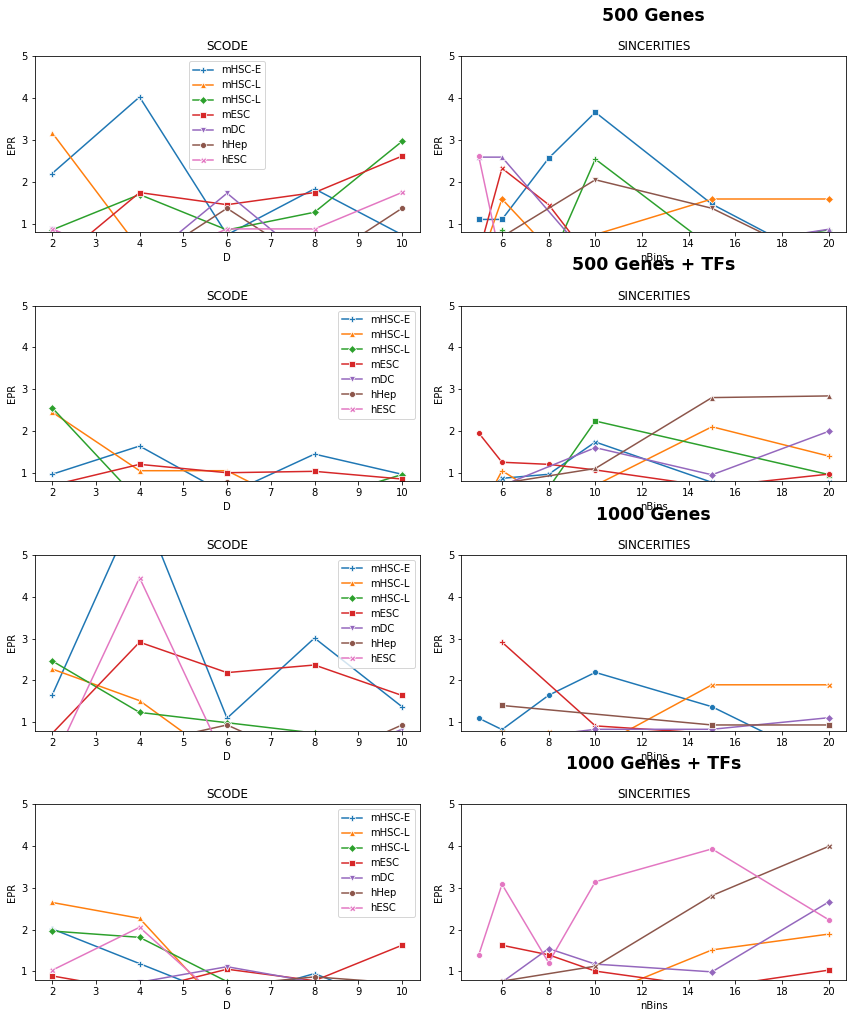

In [103]:
measures = [
#     "AUROC", 
#     "AUPRC",
    "EPR",
#     "AUPRCRatio",
]
out_dir = "outputs/viz/%s/params/" % (data_type)
os.makedirs(out_dir, exist_ok=True)
# alg_df2 = {alg: df for alg, df in alg_dfs.items() if alg != "SCRIBE"} 
# postfix = "-scribe"
for curr_measure in measures:
    out_file = "%s/%dalgs-params-%s-eval-types.pdf" % (out_dir, len(alg_order), curr_measure)
    out_file = None
    overview_plot(eval_types, alg_order, evaltype_alg_dfs, alg_params, measure=curr_measure, out_file=out_file)

In [72]:
evaltype_alg_dfs[eval_type][alg].sort_values(by=["delay", "dataset"])

,params,alg,num_edges,AUPRC,AUROC,FMAX,ePrec,eRec,delay,dataset,AUPRCRatio
9,delay5,SCRIBE,933327.0,0.003743,0.505643,0.008263,0.005486,0.005606,5,Camp2017,1.047215
10,delay5,SCRIBE,884132.0,0.003767,0.516319,0.009109,0.005504,0.005631,5,Chu2016,1.076344
10,delay5-10,SCRIBE,921214.0,0.003772,0.507792,0.008657,0.005304,0.005420,5-10,Camp2017,1.055337
9,delay5-10,SCRIBE,1196878.0,0.005256,0.490670,0.010723,0.004815,0.004857,5-10,Hayashi2018,0.975063
5,delay5-10,SCRIBE,591993.0,0.006484,0.564751,0.018614,0.010909,0.011046,5-10,Nestorowa2016-GM,1.348731
9,delay5-10,SCRIBE,216920.0,0.009998,0.550349,0.028209,0.003077,0.003155,5-10,Nestorowa2016-L,1.230183
9,delay5-10,SCRIBE,834424.0,0.003639,0.462741,0.008134,0.003536,0.003573,5-10,Shalek2014,0.891000
11,delay5-10-20-25,SCRIBE,915779.0,0.003797,0.509455,0.009131,0.005121,0.005233,5-10-20-25,Camp2017,1.062144
10,delay5-10-20-25,SCRIBE,1197357.0,0.005255,0.490796,0.010723,0.004692,0.004732,5-10-20-25,Hayashi2018,0.974862
10,delay5-10-20-25,SCRIBE,218021.0,0.010493,0.556170,0.029423,0.006154,0.006309,5-10-20-25,Nestorowa2016-L,1.291098


In [93]:
# make a table of the best parameters for each method
measure = "AUPRCRatio"
# print(','.join(['alg', 'dataset', 'parameter', measure]))
# # maximum median across all of the datasets
# for i, alg in enumerate(alg_order):
#     all_df = alg_dfs[alg]
    
#     df_med = all_df.groupby('params').median()
#     print("%s,%s,%s,%0.2f" % (
#         alg, dataset, df_med[measure].argmax(), df_med[measure].max()))    

print('\n'+','.join(['alg', 'dataset', 'parameter', measure, 'eval_type']))
# median for each alg on each dataset
for eval_type in eval_types:
    for alg in alg_order:
        df = evaltype_alg_dfs[eval_type][alg]
        if len(df.index) == 0:
            continue
        for dataset in base_datasets:
    #         print(dataset, alg)
            dataset_df = df[df['dataset'] == dataset]
            df_med = dataset_df.groupby('params').median()
            if len(df_med.index) > 0:
                print("%s,%s,%s,%0.2f,%s" % (
                    alg, dataset, df_med[measure].idxmax(), df_med[measure].max(), eval_type))        

# # group by alg
# for i, alg in enumerate(alg_order):
#     all_df = alg_dfs[alg]
#     for dataset, df_group in all_df.groupby("dataset"):
#         df_med = df_group.groupby('params').median()
#         print("%s,%s,%s,%0.2f" % (
#             alg, dataset, df_med[measure].argmax(), df_med[measure].max()))       


alg,dataset,parameter,AUPRCRatio,eval_type
SCODE,Nestorowa2016-E,D4-I50-R2,1.72,genecutoff-0.01_BF_500_varsort
SCODE,Nestorowa2016-L,D2-I50-R2,2.16,genecutoff-0.01_BF_500_varsort
SCODE,Nestorowa2016-GM,D10-I50-R2,1.65,genecutoff-0.01_BF_500_varsort
SCODE,Hayashi2018,D8-I50-R2,1.13,genecutoff-0.01_BF_500_varsort
SCODE,Shalek2014,D6-I50-R2,0.98,genecutoff-0.01_BF_500_varsort
SCODE,Camp2017,D2-I50-R2,1.07,genecutoff-0.01_BF_500_varsort
SCODE,Chu2016,D2-I50-R2,1.02,genecutoff-0.01_BF_500_varsort
SINCERITIES,Nestorowa2016-E,nBins10,1.41,genecutoff-0.01_BF_500_varsort
SINCERITIES,Nestorowa2016-L,nBins15,1.22,genecutoff-0.01_BF_500_varsort
SINCERITIES,Nestorowa2016-GM,nBins10,1.50,genecutoff-0.01_BF_500_varsort
SINCERITIES,Hayashi2018,nBins6,1.25,genecutoff-0.01_BF_500_varsort
SINCERITIES,Shalek2014,nBins6,1.42,genecutoff-0.01_BF_500_varsort
SINCERITIES,Camp2017,nBins10,1.29,genecutoff-0.01_BF_500_varsort
SINCERITIES,Chu2016,nBins5,0.91,genecutoff-0.01_BF_500_varsort
SCODE,Nestorowa2016-E,D2